# Inductive Clustering

- 클러스터링은 데이터셋에 수백만 개의 데이터 포인트가 포함된 경우 비용이 많이 들 수 있다.
- 많은 클러스터링 알고리즘들은 귀납적이지 않기 때문에 클러스터링을 다시 계산하지 않고 새로운 데이터 샘플에 직접 적용할 수 없다.
- 클러스터링을 사용하여 분류기와 귀납적 모델을 학습할 수 있다.
    - 클러스터 크기를 조정하거나 새로운 데이터를 적용할 수 있다.
    - 새로운 데이터에 대해 클러스터링을 다시 수행하지 않기 때문에, 클러스터링 결과가 일관되게 유지된다.
    - 분류기의 추론 기능을 사용하여 클러스터를 설명하거나 해석할 수 있다.
#
- 이 예제는 클러스터 레이블에서 분류기를 유도하여 클러스터링을 확장하는 meta-estimator의 일반적인 구현을 보여준다.

In [1]:
import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator, clone
from sklearn.cluster import AgglomerativeClustering
from sklearn.datasets import make_blobs
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.utils.metaestimators import available_if
from sklearn.utils.validation import check_is_fitted

N_SAMPLES = 5000
RANDOM_STATE = 42

In [2]:
def _classifier_has(attr):
    """
    기본 분류기에서 메서드를 위임할 수 있는 지 확인한다.
    학습된 분류기가 있는지 확인하고, 없으면 학습되지 않은 분류기를 확인한다.
    """
    return lambda estimator: (
        hasattr(estimator.classifier_, attr)
        if hasattr(estimator, "classifier_")
        else hasattr(estimator.classifier, attr)
    )

In [3]:
class InductiveClusterer(BaseEstimator):
    def __init__(self, clusterer, classifier):
        self.clusterer = clusterer
        self.classifier = classifier

    def fit(self, X, y=None):
        self.clusterer_ = clone(self.clusterer)
        self.classifier_ = clone(self.classifier)
        y = self.clusterer_.fit_predict(X)
        self.classifier_.fit(X, y)
        return self

    @available_if(_classifier_has("predict"))
    def predict(self, X):
        check_is_fitted(self)
        return self.classifier_.predict(X)

    @available_if(_classifier_has("decision_function"))
    def decision_function(self, X):
        check_is_fitted(self)
        return self.classifier_.decision_function(X)

In [4]:
def plot_scatter(X, color, alpha=0.5):
    return plt.scatter(X[:, 0], X[:, 1], c=color, alpha=alpha, edgecolor="k")

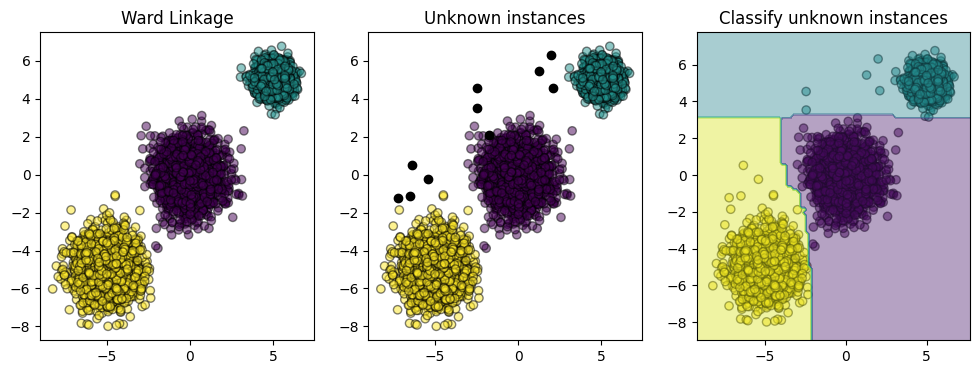

In [6]:
# 클러스터리에서 훈련 데이터를 생성한다.
X, y = make_blobs(
    n_samples=N_SAMPLES,
    cluster_std=[1.0, 1.0, 0.5],
    centers=[(-5, -5), (0, 0), (5, 5)],
    random_state=RANDOM_STATE,
)

# 훈련 데이터를 통해서 클러스터링 알고리즘을 학습하고 클러스터 라벨을 얻는다.
clusterer = AgglomerativeClustering(n_clusters=3)
cluster_labels = clusterer.fit_predict(X)

plt.figure(figsize=(12, 4))

plt.subplot(131)
plot_scatter(X, cluster_labels)
plt.title("Ward Linkage")

# 새로운 샘플을 생성하고 원래 데이터셋과 함께 플로팅한다.
X_new, y_new = make_blobs(
    n_samples=10, centers=[(-7, -1), (-2, 4), (3, 6)], random_state=RANDOM_STATE
)

plt.subplot(132)
plot_scatter(X, cluster_labels)
plot_scatter(X_new, "black", 1)
plt.title("Unknown instances")

# 알 수 없는 인스턴스에 대한 클러스터 멤버십을 예측하는 데 사용될 귀납적 학습 모델 선언
classifier = RandomForestClassifier(random_state=RANDOM_STATE)
inductive_learner = InductiveClusterer(clusterer, classifier).fit(X)

probable_clusters = inductive_learner.predict(X_new)


ax = plt.subplot(133)
plot_scatter(X, cluster_labels)
plot_scatter(X_new, probable_clusters)

# 결정 영역(Decision Region) 플로팅
DecisionBoundaryDisplay.from_estimator(
    inductive_learner, X, response_method="predict", alpha=0.4, ax=ax
)
plt.title("Classify unknown instances")

plt.show()